# EXPLORATORY DATA ANALYSIS (EDA)
This notebook performs an extensive Exploratory Data Analysis (EDA) of the app-review dataset with the goal of understanding its structure, quality, and suitability for topic-detection tasks.

The main questions guiding this analysis are:
*   What are the main characteristics of the raw text of the reviews (length, language, structure)?
*   Are there outliers or “junk” reviews?
*  Are all available features (rating, sentiment, labels, metadata) relevant to our objective?
*  How should positive and neutral reviews be treated compared to negative ones?
*  Which assumptions can be made to safely filter out or pre-process samples?
*  How much noise is present in the text (emojis, URLs, hashtags, repetitions, copy-paste behaviors)?
* Is the rating consistent with the sentiment or text content? Are there mismatches?

More questions specific to the given taxonomy:
*  Is the assigned taxonomy consistent?
*   How many labels exist and how balanced are they? How does sentiment align with the labelled topics?
*  Are some topics heavily over-represented or under-represented?
*  Do rare topics contain enough samples to be modelled?

# Task
Perform an initial raw text analysis of reviews from the `dataset_v2.xlsx` file, including calculating and visualizing review length distribution, detecting and presenting review language distribution, and conducting a structural analysis by tokenizing the text and identifying common patterns like punctuation, emojis, or special characters.

In [1]:
!pip install langdetect
!pip install emoji_regex

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import emoji_regex

## Load Dataset

Load the dataset from 'dataset_v2.xlsx' into a pandas DataFrame.


In [3]:
# Load the Excel file into a pandas DataFrame
df = pd.read_excel('/content/dataset_v2.xlsx')

# Display the first few rows of the DataFrame
display(df)

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date
0,00000038-3b3b-5102-be9a-7cf800000000,Nell’applicazione (ricarica conto)\nnon ho più...,Negative,5.0,"[""problemi_ricarica""]",0.0,1.0.0,2024-10-01
1,00000038-3b3b-5102-bed4-a60f00000000,mi succede svariate volte che non riesco ad ac...,Negative,1.0,"[""problemi_accesso""]",0.0,1.0.0,2024-10-02
2,00000038-3b3b-5102-bed5-edb100000000,"Applicazione troppo lenta, non si riesce a far...",Negative,1.0,"[""problemi_sistema""]",0.0,1.0.0,2024-10-02
3,00000038-3b3b-5102-bf2b-621400000000,"ho hype da due anni, mi è arrivata la nuova ca...",Negative,4.0,"[""problemi_gestione_carta""]",0.0,1.0.0,2024-10-04
4,00000038-3b3b-5102-c000-0fc900000000,Da oggi sto riscontrando problemi ad accedere ...,Negative,1.0,"[""problemi_accesso"",""problemi_assistenza""]",0.0,1.0.0,2024-10-08
...,...,...,...,...,...,...,...,...
6145,NaN,è una vergogna pagare 3 euro al mese e avere p...,negative,NaN,"[""problemi_bonifici"",""problemi_di_accesso""]",NaN,1.0.0,NaT
6146,NaN,“Accesso biometrico non valido “ comincia a da...,negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT
6147,NaN,“Accesso biometrico non valido” è un messaggio...,negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT
6148,NaN,“Funzione” che richiedo da tempo: una sezione ...,negative,NaN,"[""problemi_di_comunicazione""]",NaN,1.0.0,NaT


## Basic Pre-Processing

The sentiment labels are both lowercased and uppercased, so we need to normalize them.

In [4]:
df['sentiment'].unique()


array(['Negative', 'Positive', 'Neutral', 'negative'], dtype=object)

In [5]:
df['sentiment'] = df['sentiment'].astype(str).str.lower()
df['sentiment'].unique()

array(['negative', 'positive', 'neutral'], dtype=object)

## Analyze Review Length

Calculate the length of each review and visualize the distribution of review lengths. This will involve counting characters or words in the review text.

To analyze the review length, I will calculate the character length of each review, store it in a new column, and then visualize its distribution using a histogram.




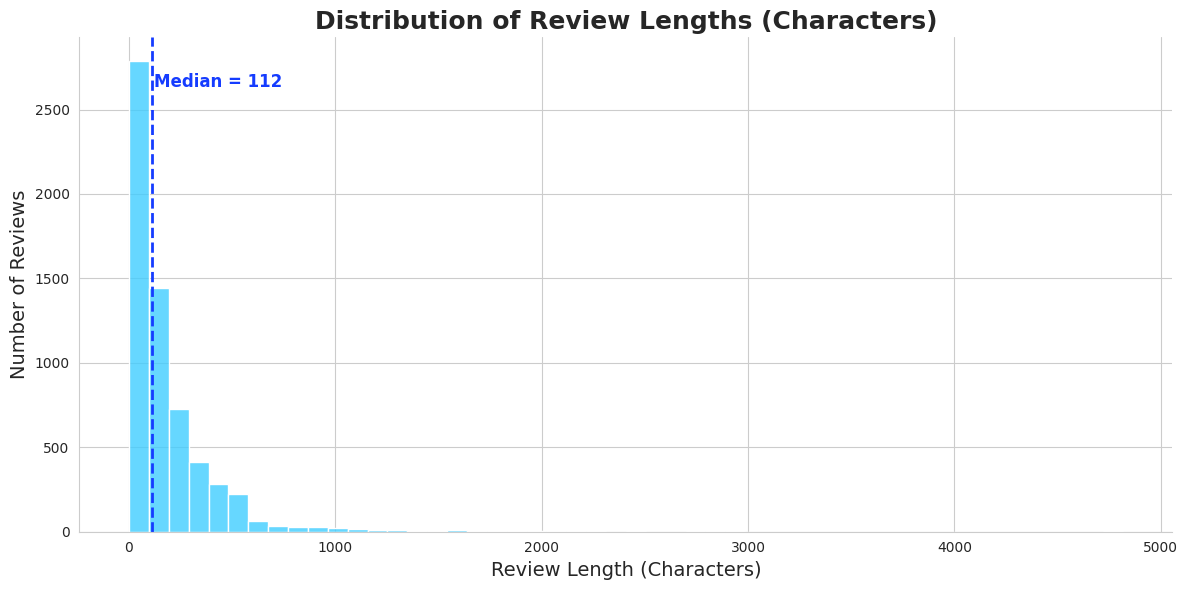

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the character length
df['review_length'] = df['review'].astype(str).apply(len)

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# KDE + Hist
sns.histplot(
    df['review_length'],
    bins=50,
    kde=False,
    color="#40cdff", # Color for histogram bars
    edgecolor="white",
    alpha=0.8,

)

# Add median line
median_val = df['review_length'].median()
plt.axvline(median_val, color="#153cff", linestyle="--", linewidth=2)
plt.text(median_val + 10, plt.ylim()[1]*0.9,
         f"Median = {int(median_val)}",
         color="#153cff", fontsize=12, fontweight="bold")

# Title & labels
plt.title("Distribution of Review Lengths (Characters)", fontsize=18, fontweight="bold")
plt.xlabel("Review Length (Characters)", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

# Clean the style
sns.despine()

plt.tight_layout()
plt.show()

Now we can apply the same analysis on the words length of the reviews.

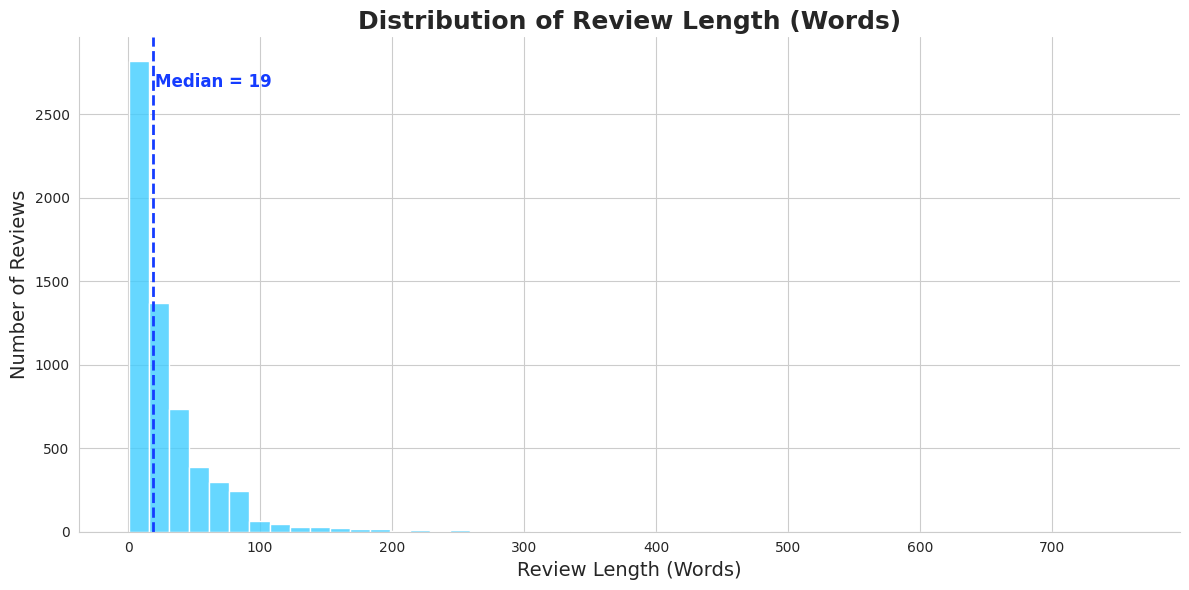

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the number of words
df['review_word_count'] = df['review'].astype(str).apply(lambda x: len(x.split()))

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# HISTOGRAM
sns.histplot(
    df['review_word_count'],
    bins=50,
    kde=False,
    color="#40cdff",   # histogram color
    edgecolor="white",
    alpha=0.8
)

# Add median line
median_words = df['review_word_count'].median()
plt.axvline(median_words, color="#153cff", linestyle="--", linewidth=2)
plt.text(median_words + 1, plt.ylim()[1]*0.9,
         f"Median = {int(median_words)}",
         color="#153cff", fontsize=12, fontweight="bold")

# Titles & labels
plt.title("Distribution of Review Length (Words)", fontsize=18, fontweight="bold")
plt.xlabel("Review Length (Words)", fontsize=14)
plt.ylabel("Number of Reviews", fontsize=14)

# Clean style
sns.despine()

plt.tight_layout()
plt.show()


In [8]:
df.describe()

,rating,is_labels_validated,review_date,review_length,review_word_count
count,3735.000000,3735.000000,3735,6150.000000,6150.000000
mean,3.057028,0.543775,2025-05-06 11:41:18.072289280,193.969593,31.844390
min,1.000000,0.000000,2024-10-01 00:00:00,1.000000,1.000000
25%,1.000000,0.000000,2025-01-20 00:00:00,50.000000,8.000000
50%,3.000000,1.000000,2025-05-11 00:00:00,112.000000,19.000000
75%,5.000000,1.000000,2025-08-27 00:00:00,239.000000,39.000000
max,5.000000,1.000000,2025-11-18 00:00:00,4816.000000,759.000000
std,1.816196,0.498147,NaN,285.678191,46.071307


### Analysis of Extremely Short Reviews

Filter the DataFrame to identify reviews with a character length less than 20. Display a sample of these reviews to inspect their content. Then, visualize the sentiment distribution of these short reviews using a bar plot to determine if they are meaningful or require special handling.



Sample of short reviews (length < 20 characters):


,review,review_length,sentiment
3297,top,3,positive
3021,Ottima e funzionale,19,positive
3905,Assistenza nulla,16,negative
2116,Ottimo servizio,16,positive
2675,Ottima scelta \n\n,16,positive
1310,Fantastica,10,positive
1155,ok,2,positive
2994,ottimo,6,positive
967,davvero bella,13,positive
3100,Ottima,6,positive


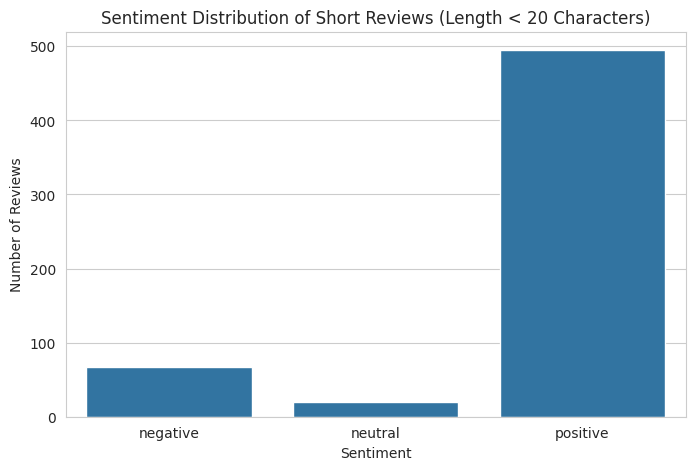

In [9]:
# 1. Filter the DataFrame for reviews with character length less than 20
short_reviews_df = df[df['review_length'] < 20].copy()

# 2. Display a sample of these short reviews
print("\nSample of short reviews (length < 20 characters):")
display(short_reviews_df[['review', 'review_length', 'sentiment']].sample(min(10, len(short_reviews_df))))

# 3. Visualize the sentiment distribution of these short reviews
plt.figure(figsize=(8, 5))
sns.countplot(data=short_reviews_df, x='sentiment', order=['negative', 'neutral', 'positive'])
plt.title('Sentiment Distribution of Short Reviews (Length < 20 Characters)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


##Analyze the trends of reviews over time

Calculate the volume of reviews in each month, where the date of the review is available, and visualize the trend over time.

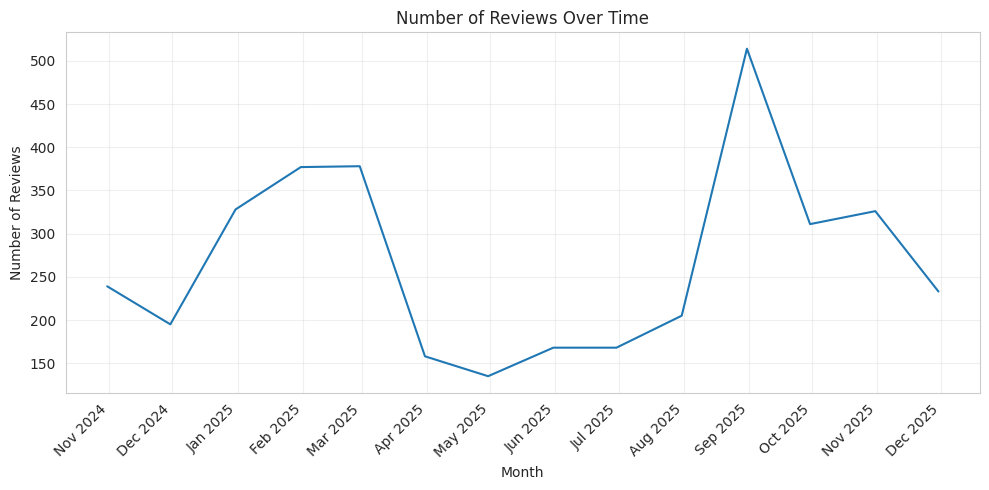

In [10]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

df["date"] = pd.to_datetime(df["review_date"])

monthly_reviews = df.set_index("date").resample("ME")["review"].count()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(monthly_reviews.index, monthly_reviews.values)

# Axis labels
ax.set_title("Number of Reviews Over Time")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Reviews")

# Format X-axis as Month Year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%b %Y"))

plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


##Analyze the distribution of the languages of the reviews

To analyze the language distribution, we will use the `langdetect` library to identify the language of each review, store it in a new column, and then visualize the count of each detected language using a bar plot.



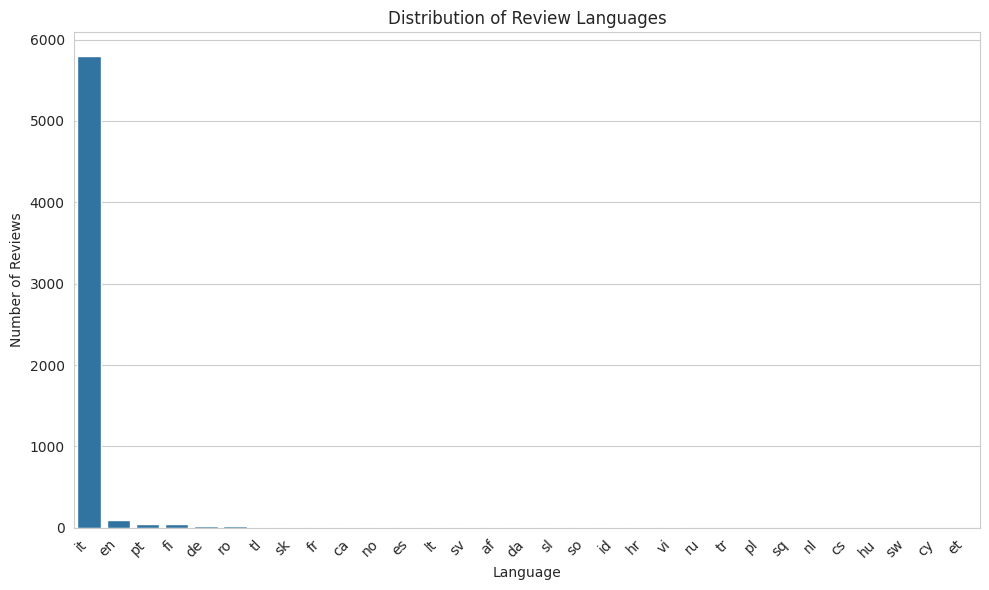

In [11]:
# Set seed for reproducibility
DetectorFactory.seed = 0

# Define a function to safely detect language
def safe_detect_language(text):
    try:
        return detect(str(text))
    except:
        return np.nan

# Apply the function to the 'review' column
df['language'] = df['review'].apply(safe_detect_language)

# Visualize the distribution of detected languages
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='language', order=df['language'].value_counts().index)
plt.title('Distribution of Review Languages')
plt.xlabel('Language')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

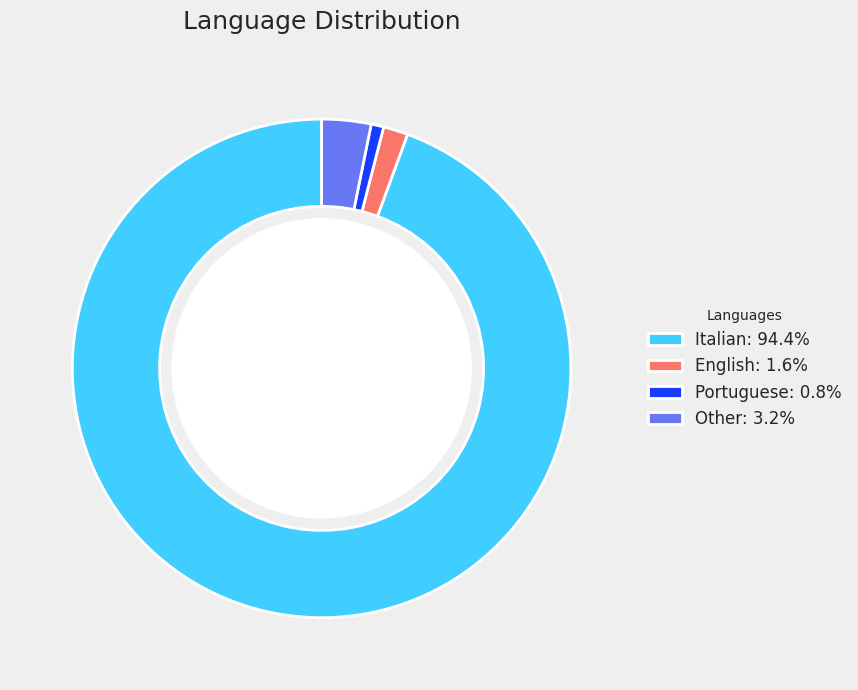

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Language mapping
lang_map = {
    "it": "Italian",
    "en": "English",
    "pt": "Portuguese",
    "es": "Spanish",
    "fr": "French",
    "de": "German",
    "nan": "Unknown"
}

df['language_full'] = df['language'].map(lang_map).fillna(df['language'])

# Count languages
lang_counts = df['language_full'].value_counts()

threshold = 0.008  # 0.8%
total = lang_counts.sum()

major_langs = lang_counts[lang_counts / total >= threshold]
minor_langs = lang_counts[lang_counts / total < threshold]

if len(minor_langs) > 0:
    major_langs["Other"] = minor_langs.sum()

# Colors
colors_list = ["#40cdff", "#fb766a", "#153cff", "#6877f3"]
colors = (colors_list * ((len(major_langs) // len(colors_list)) + 1))[:len(major_langs)]

# Percentages for legend
percentages = (major_langs / major_langs.sum() * 100).round(1)

# --- PLOT ---
plt.figure(figsize=(10, 7), facecolor="#efefef")

wedges, texts = plt.pie(
    major_langs,
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'width': 0.35},
)

# Create donut hole
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# -------- LEGEND ONLY (no numbers inside plot) --------
legend_labels = [
    f"{lang}: {percentages.iloc[i]}%"
    for i, (lang, count) in enumerate(major_langs.items())
]

plt.legend(
    wedges,
    legend_labels,
    title="Languages",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize=12
)

plt.title("Language Distribution", fontsize=18, pad=20)
plt.tight_layout()
plt.show()


##Analyze the punctuation and emojis distributions

Now that the review length and language distribution have been analyzed, the next step is to perform a structural analysis of the text. This involves tokenizing the text, identifying common patterns like punctuation, emojis, and special characters, and then visualizing their distributions. This will help understand the 'structure' of the reviews as requested in the overall task.



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


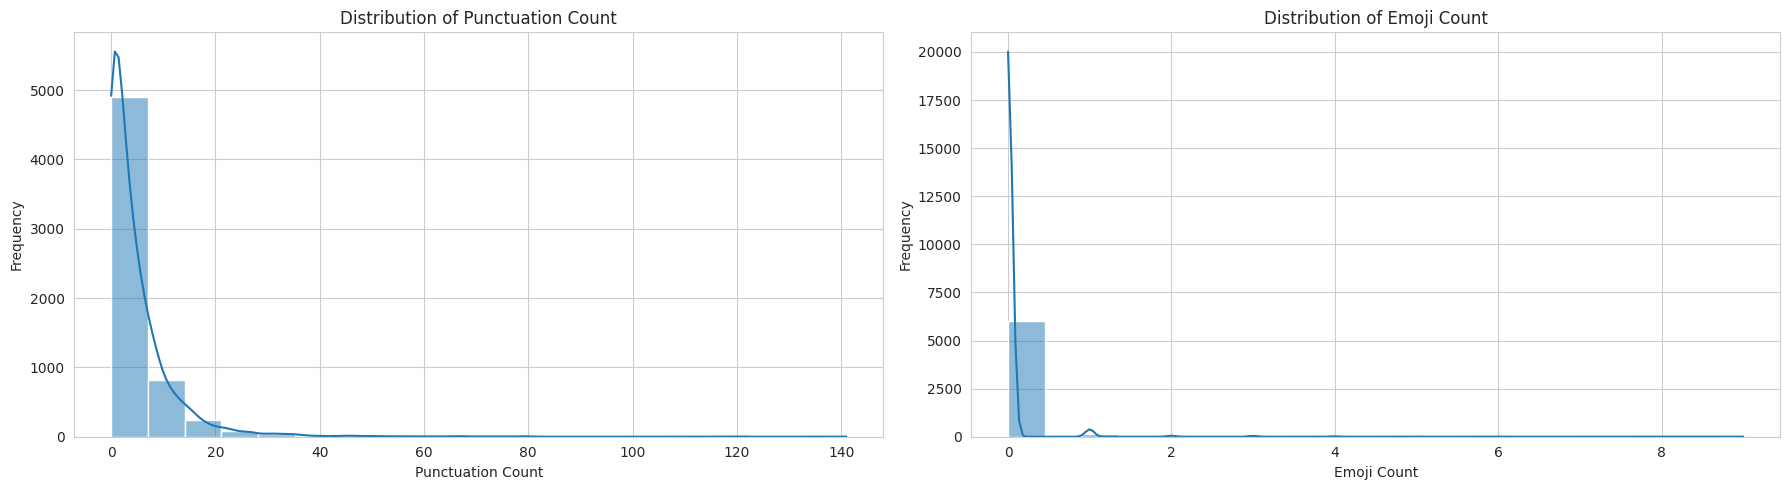

In [13]:
import nltk
nltk.download('punkt_tab')

# Tokenize the reviews
df['tokens'] = df['review'].apply(word_tokenize)

# Identify punctuation
punctuation_pattern = r"[^\w\s]"

# Punctuation_count is the number of punctuation in the review
df['punctuation_count'] = df['review'].apply(lambda x: len(re.findall(punctuation_pattern, x)))

# Identify emojis
emoji_pattern = emoji_regex.emoji_regex
df['emoji_count'] = df['review'].apply(lambda x: len(re.findall(emoji_pattern, x)))

# Visualize distributions of punctuation, emojis, and special characters counts
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(df['punctuation_count'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Punctuation Count')
axes[0].set_xlabel('Punctuation Count')
axes[0].set_ylabel('Frequency')

sns.histplot(df['emoji_count'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Emoji Count')
axes[1].set_xlabel('Emoji Count')
axes[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

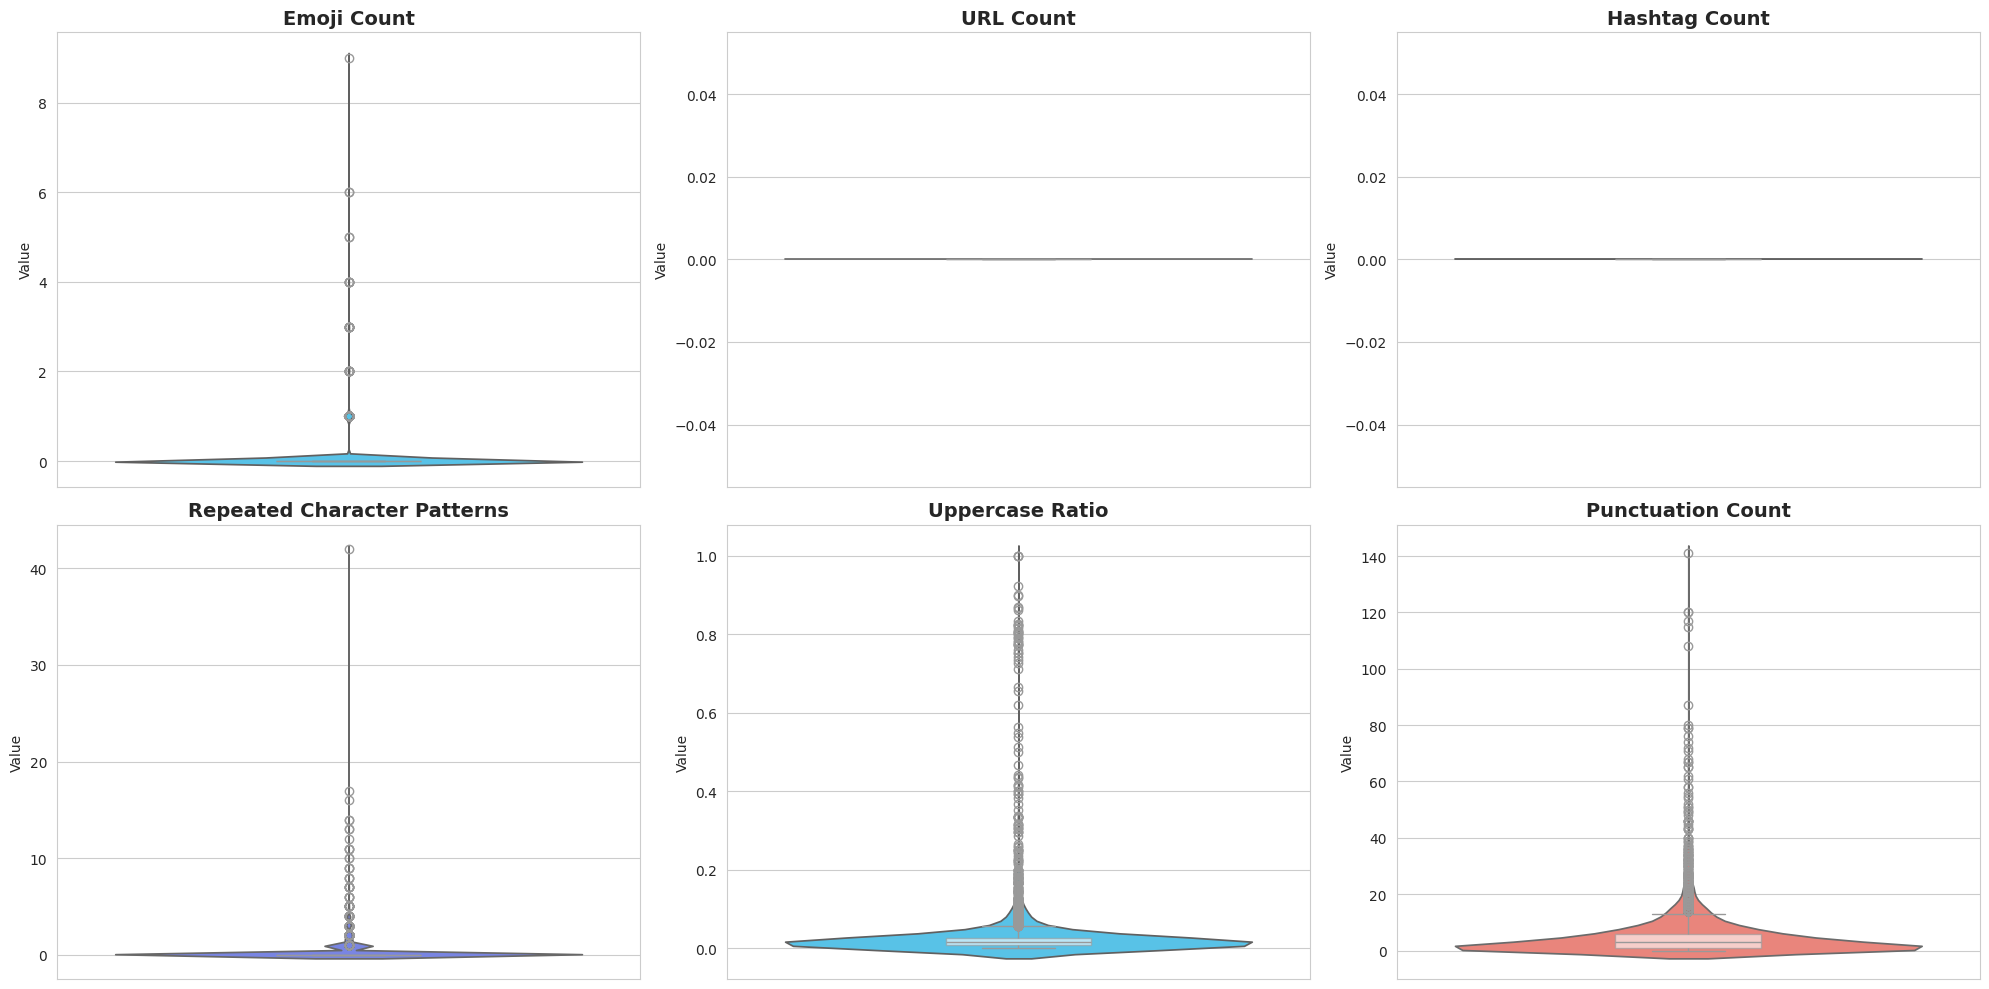

In [14]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import emoji_regex

# ---------------------------
#   NOISE FEATURE EXTRACTION
# ---------------------------

# Count emojis
# Identify emojisì
emoji_pattern = emoji_regex.emoji_regex
df['emoji_count'] = df['review'].apply(lambda x: len(re.findall(emoji_pattern, x)))

# Count URLs
df["url_count"] = df["review"].apply(lambda x: len(re.findall(r"http\S+|www\.\S+", str(x))))

# Count hashtags
df["hashtag_count"] = df["review"].apply(lambda x: str(x).count('#'))

# Count repeated characters (>=3)
df["repeated_chars"] = df["review"].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))

# Uppercase ratio
def uppercase_ratio(text):
    text = str(text)
    if len(text) == 0:
        return 0
    upp = sum(1 for c in text if c.isupper())
    return upp / len(text)

df["uppercase_ratio"] = df["review"].apply(uppercase_ratio)

# Punctuation count
punct_pattern = r"[^\w\s]"
df["punctuation_count"] = df["review"].apply(lambda x: len(re.findall(punct_pattern, str(x))))


# ---------------------------
#        NICE PLOTS
# ---------------------------

noise_features = [
    "emoji_count",
    "url_count",
    "hashtag_count",
    "repeated_chars",
    "uppercase_ratio",
    "punctuation_count"
]

titles = [
    "Emoji Count",
    "URL Count",
    "Hashtag Count",
    "Repeated Character Patterns",
    "Uppercase Ratio",
    "Punctuation Count"
]

colors = ["#40cdff", "#fb766a", "#153cff", "#6877f3", "#40cdff", "#fb766a"]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for ax, feature, title, color in zip(axes.flatten(), noise_features, titles, colors):
    # violinplot (smooth distribution)
    sns.violinplot(
        y=df[feature],
        ax=ax,
        color=color,
        inner=None
    )
    # boxplot overlay (to show outliers)
    sns.boxplot(
        y=df[feature],
        ax=ax,
        color="white",
        width=0.25,
        boxprops=dict(alpha=0.6)
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Value")

plt.tight_layout()
plt.show()


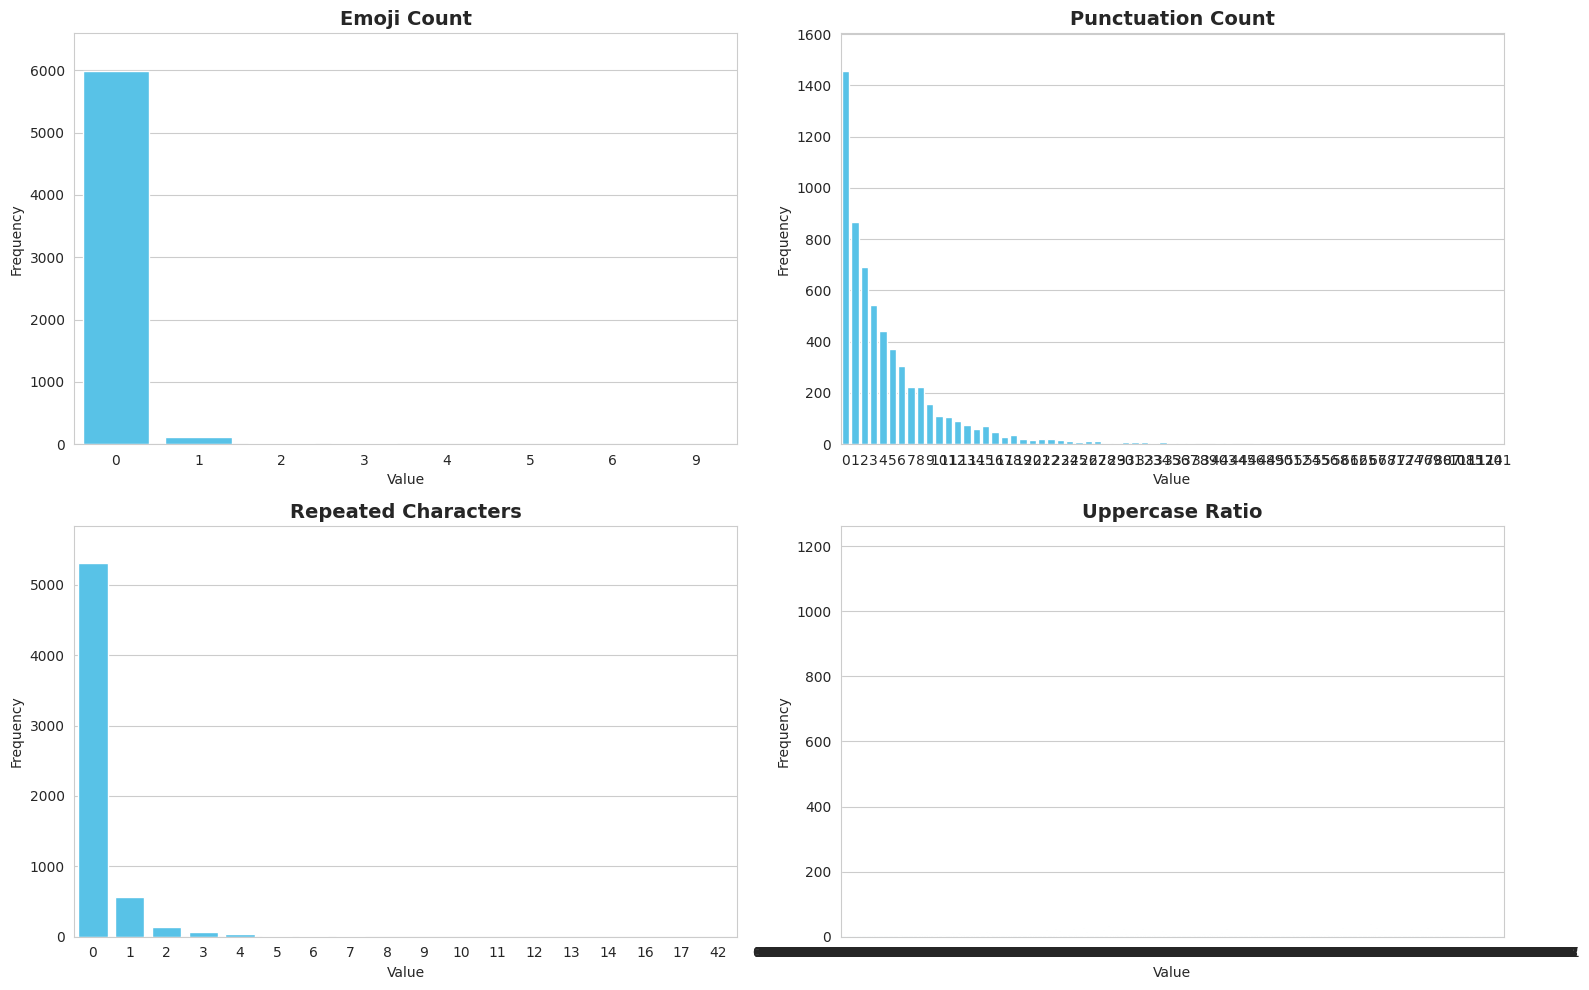

In [15]:
features = ['emoji_count', 'punctuation_count', 'repeated_chars', 'uppercase_ratio']
titles = ['Emoji Count', 'Punctuation Count', 'Repeated Characters', 'Uppercase Ratio']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for feature, ax, title in zip(features, axes.flatten(), titles):
    sns.countplot(x=df[feature], ax=ax, color="#40cdff")
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.set_ylim(0, df[feature].value_counts().max() * 1.1)

plt.tight_layout()
plt.show()

## Feature Importance Analysis

To assess feature importance, we need a target variable and a machine learning model. For demonstration purposes, we will treat 'sentiment' as our target variable and build a `RandomForestClassifier`. The input features will include the TF-IDF representation of the review text, alongside the numerical features we've extracted (review length, punctuation count, emoji count, and special character count).

First, we'll preprocess the data by vectorizing the text and scaling the numerical features. Then, we'll train a model and extract feature importances.

In [16]:
display(df)

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,date,language,language_full,tokens,punctuation_count,emoji_count,url_count,hashtag_count,repeated_chars,uppercase_ratio
0,00000038-3b3b-5102-be9a-7cf800000000,Nell’applicazione (ricarica conto)\nnon ho più...,negative,5.0,"[""problemi_ricarica""]",0.0,1.0.0,2024-10-01,132,19,2024-10-01,it,Italian,"[Nell, ’, applicazione, (, ricarica, conto, ),...",5,0,0,0,0,0.007576
1,00000038-3b3b-5102-bed4-a60f00000000,mi succede svariate volte che non riesco ad ac...,negative,1.0,"[""problemi_accesso""]",0.0,1.0.0,2024-10-02,277,54,2024-10-02,it,Italian,"[mi, succede, svariate, volte, che, non, riesc...",3,0,0,0,0,0.000000
2,00000038-3b3b-5102-bed5-edb100000000,"Applicazione troppo lenta, non si riesce a far...",negative,1.0,"[""problemi_sistema""]",0.0,1.0.0,2024-10-02,201,33,2024-10-02,it,Italian,"[Applicazione, troppo, lenta, ,, non, si, ries...",4,0,0,0,0,0.009950
3,00000038-3b3b-5102-bf2b-621400000000,"ho hype da due anni, mi è arrivata la nuova ca...",negative,4.0,"[""problemi_gestione_carta""]",0.0,1.0.0,2024-10-04,211,37,2024-10-04,it,Italian,"[ho, hype, da, due, anni, ,, mi, è, arrivata, ...",2,0,0,0,0,0.000000
4,00000038-3b3b-5102-c000-0fc900000000,Da oggi sto riscontrando problemi ad accedere ...,negative,1.0,"[""problemi_accesso"",""problemi_assistenza""]",0.0,1.0.0,2024-10-08,248,42,2024-10-08,it,Italian,"[Da, oggi, sto, riscontrando, problemi, ad, ac...",4,0,0,0,0,0.024194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6145,NaN,è una vergogna pagare 3 euro al mese e avere p...,negative,NaN,"[""problemi_bonifici"",""problemi_di_accesso""]",NaN,1.0.0,NaT,153,25,NaT,it,Italian,"[è, una, vergogna, pagare, 3, euro, al, mese, ...",8,0,0,0,1,0.013072
6146,NaN,“Accesso biometrico non valido “ comincia a da...,negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT,75,11,NaT,it,Italian,"[“, Accesso, biometrico, non, valido, “, comin...",3,0,0,0,0,0.013333
6147,NaN,“Accesso biometrico non valido” è un messaggio...,negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT,110,18,NaT,it,Italian,"[“, Accesso, biometrico, non, valido, ”, è, un...",3,0,0,0,0,0.018182
6148,NaN,“Funzione” che richiedo da tempo: una sezione ...,negative,NaN,"[""problemi_di_comunicazione""]",NaN,1.0.0,NaT,250,36,NaT,it,Italian,"[“, Funzione, ”, che, richiedo, da, tempo, :, ...",8,0,0,0,0,0.008000


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Drop rows where 'sentiment' is NaN (target)
df_filtered = df.dropna(subset=['sentiment']).copy()

# ----- FEATURES -----
numeric_features = ['review_length', 'punctuation_count', 'emoji_count',
                     'rating']

categorical_features = ['labels', 'language']

date_features = ['review_date']

# Create X and y
X = df_filtered[numeric_features + categorical_features + date_features]
y = df_filtered['sentiment']
X = X.dropna()
y = y.loc[X.index]


# ----- PREPROCESSING -----

# Convert date → number (e.g., timestamp)
X['review_date'] = pd.to_datetime(X['review_date'], errors='coerce').astype(int) / 10**9

# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
        ('date', 'passthrough', date_features)
    ]
)

# ----- PIPELINE -----
model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=None
    ))
])

# ----- TRAIN/TEST SPLIT -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----- FIT -----
model_pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['labels', 'language']),
                                                 ('num', 'passthrough',
                                                  ['review_length',
                                                   'punctuation_count',
                                                   'emoji_count', 'rating']),
                                                 ('date', 'passthrough',
                                                  ['review_date'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

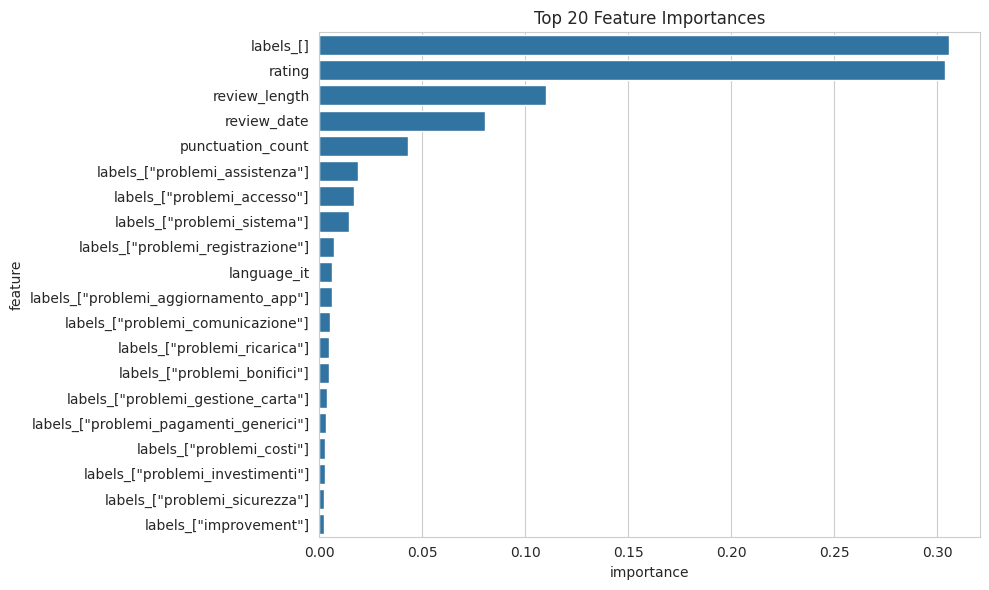

In [18]:
# Step 1: recupera nomi delle feature categoriche dopo OneHotEncoding
cat_encoder = model_pipeline.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Step 2: aggiungi i nomi delle feature numeriche
num_feature_names = numeric_features

# Step 3: aggiungi il nome della colonna data
date_feature_names = ['review_date']

# Lista completa
all_feature_names = np.concatenate([
    cat_feature_names,
    num_feature_names,
    date_feature_names
])
importances = model_pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
feature_importance_df.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(20),
    x='importance',
    y='feature'
)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()


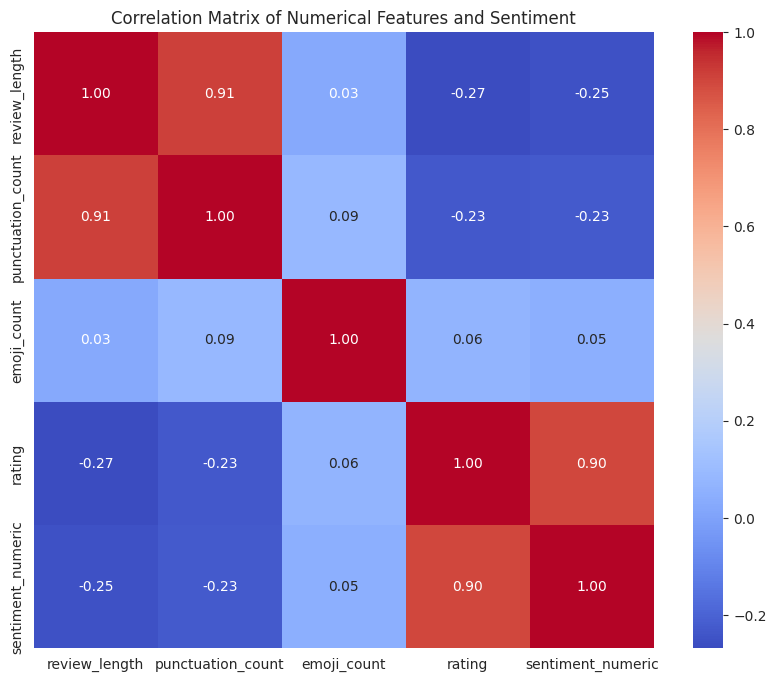

In [19]:
# Map sentiment to numerical values for correlation analysis
sentiment_mapping = {'Negative': -1, 'negative': -1, 'Neutral': 0, 'neutral': 0, 'Positive': 1, 'positive': 1}
df_filtered['sentiment_numeric'] = df_filtered['sentiment'].map(sentiment_mapping)

# Select numerical columns for correlation analysis
numerical_cols = ['review_length', 'punctuation_count', 'emoji_count',
                     'rating', 'sentiment_numeric']
# Calculate the correlation matrix
correlation_matrix = df_filtered[numerical_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Sentiment')
plt.show()


## Sentiment and Rating Distribution

Let's visualize the distribution of sentiment categories and review ratings to understand their balance.

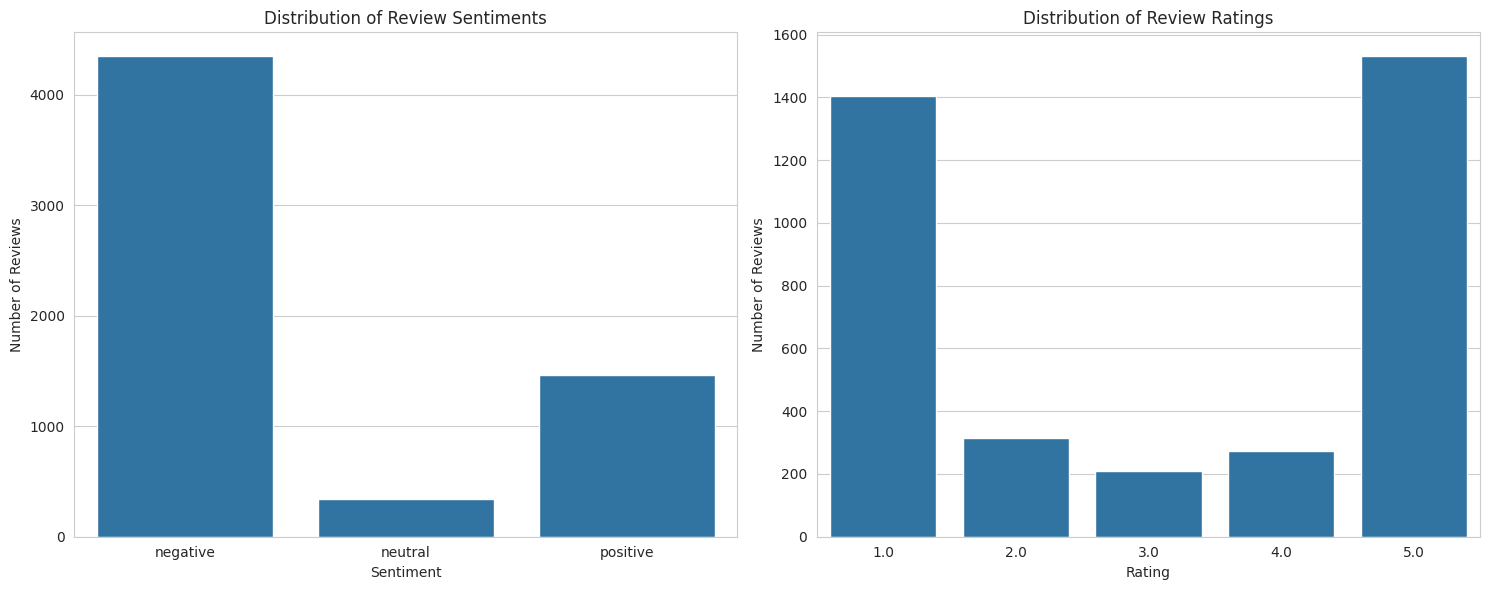

In [20]:
# Create subplots for sentiment and rating distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot sentiment distribution
sns.countplot(data=df_filtered, x='sentiment', order=['negative', 'neutral', 'positive'], ax=axes[0])
axes[0].set_title('Distribution of Review Sentiments')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Reviews')

# Plot rating distribution
sns.countplot(data=df_filtered, x='rating', ax=axes[1])
axes[1].set_title('Distribution of Review Ratings')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Number of Reviews')

plt.tight_layout()
plt.show()


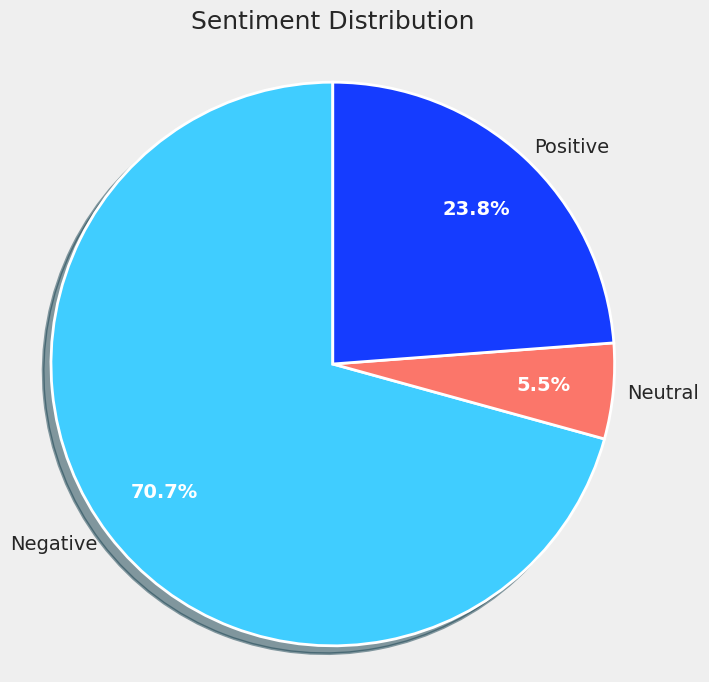

In [21]:
import matplotlib.pyplot as plt

# Colori personalizzati
colors_list = ["#40cdff", "#fb766a", "#153cff"]

# Conta le occorrenze dei sentiment
sentiment_counts = df['sentiment'].value_counts().reindex(['negative', 'neutral', 'positive'])

labels = ["Negative", "Neutral", "Positive"]  # Etichette più belle
sizes = sentiment_counts.values

plt.figure(figsize=(8, 8), facecolor="#efefef")


# Pie chart migliorato
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    pctdistance=0.75,        # Avvicina la percentuale al centro
    labeldistance=1.05,       # Allontana le etichette
    startangle=90,
    colors=colors_list,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2},  # Bordo più elegante
    shadow=True
)

# Styling del testo
for text in texts:
    text.set_fontsize(14)
for autotext in autotexts:
    autotext.set_fontsize(14)
    autotext.set_color("white")
    autotext.set_weight("bold")

plt.title("Sentiment Distribution", fontsize=18, pad=20)
plt.axis('equal')

plt.show()



### Sentiment and Rating Combinations

To understand how sentiment aligns with specific ratings, let's create a table showing the count for each sentiment-rating combination.

In [22]:
# Create a cross-tabulation of 'sentiment' and 'rating'
sentiment_rating_counts = pd.crosstab(df_filtered['sentiment'], df_filtered['rating'])

# Display the table
display(sentiment_rating_counts)

rating,1.0,2.0,3.0,4.0,5.0
sentiment,,,,,
negative,1379,295,155,67,38
neutral,21,19,50,120,127
positive,4,1,6,87,1366


In [23]:
df_negative5 = df[(df['sentiment'] == "negative") & (df["rating"] == 5.0)].copy()
display(df_negative5)

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,date,language,language_full,tokens,punctuation_count,emoji_count,url_count,hashtag_count,repeated_chars,uppercase_ratio
0,00000038-3b3b-5102-be9a-7cf800000000,Nell’applicazione (ricarica conto)\nnon ho più...,negative,5.0,"[""problemi_ricarica""]",0.0,1.0.0,2024-10-01,132,19,2024-10-01,it,Italian,"[Nell, ’, applicazione, (, ricarica, conto, ),...",5,0,0,0,0,0.007576
54,00000038-3b3b-5102-cce0-93e300000000,Sono 2 giorni che non riesco ad accedere all’ ...,negative,5.0,"[""problemi_accesso""]",0.0,1.0.0,2024-12-04,54,11,2024-12-04,it,Italian,"[Sono, 2, giorni, che, non, riesco, ad, accede...",1,0,0,0,0,0.037037
56,00000038-3b3b-5102-ccf5-1d7500000000,Non riesco ad entrare con Face ID. Come fare?,negative,5.0,"[""problemi_accesso""]",0.0,1.0.0,2024-12-05,45,9,2024-12-05,it,Italian,"[Non, riesco, ad, entrare, con, Face, ID, ., C...",2,0,0,0,0,0.111111
120,00000038-3b3b-5102-dff5-14a000000000,Mi obbliga ad aggiornare poi non funziona,negative,5.0,"[""problemi_aggiornamento_app""]",0.0,1.0.0,2025-02-23,41,7,2025-02-23,it,Italian,"[Mi, obbliga, ad, aggiornare, poi, non, funziona]",0,0,0,0,0,0.024390
128,00000038-3b3b-5102-e13e-9ae500000000,Non riesco a fare l’aggiornamento,negative,5.0,"[""problemi_aggiornamento_app""]",1.0,1.0.0,2025-03-01,33,5,2025-03-01,it,Italian,"[Non, riesco, a, fare, l, ’, aggiornamento]",1,0,0,0,0,0.030303
174,00000038-3b3b-5102-ef77-61ab00000000,Non è possibile eliminare facilmente un pagame...,negative,5.0,"[""problemi_pagamenti_generici"",""improvement""]",1.0,1.0.0,2025-05-01,79,12,2025-05-01,it,Italian,"[Non, è, possibile, eliminare, facilmente, un,...",1,0,0,0,0,0.012658
218,00000038-3b3b-5102-fa98-69aa00000000,A volte difficile fare operazioni,negative,5.0,"[""problemi_usabilità""]",1.0,1.0.0,2025-06-19,33,5,2025-06-19,it,Italian,"[A, volte, difficile, fare, operazioni]",0,0,0,0,0,0.030303
277,00000038-3b3b-5103-0496-057500000000,Spesso il riconoscimento biometrico non funzio...,negative,5.0,"[""problemi_accesso""]",1.0,1.0.0,2025-07-31,196,28,2025-07-31,it,Italian,"[Spesso, il, riconoscimento, biometrico, non, ...",3,0,0,0,0,0.015306
386,00000038-3b3b-5103-099c-4b0600000000,"Appena aggiornata e non accede più, mi continu...",negative,5.0,"[""problemi_aggiornamento_app""]",1.0,1.0.0,2025-08-22,102,16,2025-08-22,it,Italian,"[Appena, aggiornata, e, non, accede, più, ,, m...",3,0,0,0,0,0.019608
387,00000038-3b3b-5103-099c-4b0600000000,"Appena aggiornata e non accede più, mi continu...",negative,5.0,"[""problemi_aggiornamento_app""]",1.0,2.0.0,2025-08-22,72,11,2025-08-22,it,Italian,"[Appena, aggiornata, e, non, accede, più, ,, m...",2,0,0,0,0,0.013889


In [24]:
df_positive1 = df[(df['sentiment'] == "positive") & (df["rating"] == 1.0)].copy()
display(df_positive1)

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,date,language,language_full,tokens,punctuation_count,emoji_count,url_count,hashtag_count,repeated_chars,uppercase_ratio
248,00000038-3b3b-5102-ff33-e35f00000000,Una banca che promuove dí tutto dai viaggi all...,positive,1.0,"[""problemi_comunicazione""]",1.0,1.0.0,2025-07-09,54,10,2025-07-09,it,Italian,"[Una, banca, che, promuove, dí, tutto, dai, vi...",0,0,0,0,0,0.018519
2368,6866cea6deabacc28c852cba,"MI CHIAMO ANDREA RICCI, HO 43 ANNI E VIVO A TO...",positive,1.0,[],1.0,1.0.0,2025-07-03,2175,331,2025-07-03,pt,Portuguese,"[MI, CHIAMO, ANDREA, RICCI, ,, HO, 43, ANNI, E...",52,0,0,0,3,0.802759
2472,68a735f135c153e0c4fbefea,La mia esperienza con 𝙼𝚟𝚞𝚝𝚣 è stata molto posi...,positive,1.0,[],1.0,1.0.0,2025-08-21,239,38,2025-08-21,it,Italian,"[La, mia, esperienza, con, 𝙼𝚟𝚞𝚝𝚣, è, stata, mo...",5,0,0,0,0,0.020921
2473,68a735f135c153e0c4fbefea,La mia esperienza con 𝙼𝚟𝚞𝚝𝚣 è stata molto posi...,positive,1.0,[],1.0,2.0.0,2025-08-21,239,38,2025-08-21,it,Italian,"[La, mia, esperienza, con, 𝙼𝚟𝚞𝚝𝚣, è, stata, mo...",5,0,0,0,0,0.020921


### Uppercase Flag for Reviews

To identify reviews with a high proportion of uppercase characters, I'll create a new column named `is_50_percent_uppercase`. This flag will be `True` if at least 50% of the alphabetic characters in the review are uppercase, and `False` otherwise.

In [25]:
def more_than_half_uppercase_words(text):
    words = text.split()
    uppercase_words = sum(word.isalpha() and word.isupper() for word in words)
    return uppercase_words / len(words) > 0.5

df['is_50_percent_uppercase'] = df['review'].apply(more_than_half_uppercase_words)


In [26]:
df_upp = df[df['is_50_percent_uppercase'] == True].copy()
display(df_upp)

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,...,language,language_full,tokens,punctuation_count,emoji_count,url_count,hashtag_count,repeated_chars,uppercase_ratio,is_50_percent_uppercase
30,00000038-3b3b-5102-c7cc-dd3600000000,BRAVISSIMI,positive,5.0,[],0.0,1.0.0,2024-11-12,10,1,...,de,German,[BRAVISSIMI],0,0,0,0,0,1.000000,True
74,00000038-3b3b-5102-d393-14dc00000000,SOLDI BUTTATI,neutral,1.0,"[""problemi_risparmi""]",0.0,1.0.0,2025-01-03,13,2,...,de,German,"[SOLDI, BUTTATI]",0,0,0,0,0,0.923077,True
390,00000038-3b3b-5103-09de-be6d00000000,"Ho fatto varie segnalazioni, mi hanno detto di...",negative,1.0,"[""problemi_sistema"",""problemi_accesso""]",1.0,1.0.0,2025-08-23,491,85,...,it,Italian,"[Ho, fatto, varie, segnalazioni, ,, mi, hanno,...",9,0,0,0,0,0.513238,True
392,00000038-3b3b-5103-09de-be6d00000000,E DA PIÙ DI UNA SETTIMANA CHE MI FANNO CAMBIAR...,negative,1.0,"[""problemi_sistema""]",1.0,2.0.0,2025-08-23,183,36,...,pt,Portuguese,"[E, DA, PIÙ, DI, UNA, SETTIMANA, CHE, MI, FANN...",1,0,0,0,0,0.803279,True
438,00000038-3b3b-5103-0c0c-9a0900000000,HO INVIATO UNA PEC COME RECLAMO MA NESSUNO MI ...,negative,1.0,"[""problemi_assistenza""]",1.0,2.0.0,2025-09-01,54,10,...,pt,Portuguese,"[HO, INVIATO, UNA, PEC, COME, RECLAMO, MA, NES...",0,0,0,0,0,0.833333,True
1020,29d715e7-8ade-4fdb-b94b-8ced230e37f5,"Fate schifo, Chiedete selfie e NON DATE LA POS...",negative,1.0,"[""problemi_registrazione""]",0.0,1.0.0,2025-02-26,147,26,...,de,German,"[Fate, schifo, ,, Chiedete, selfie, e, NON, DA...",8,0,0,0,1,0.619048,True
1099,343a6ffd-022f-4cbe-874b-a8bc9a7da82f,"Conto buono, veloce e funzionante. APPLICAZION...",negative,1.0,"[""problemi_sistema""]",0.0,1.0.0,2024-12-10,244,37,...,it,Italian,"[Conto, buono, ,, veloce, e, funzionante, ., A...",13,0,0,0,1,0.655738,True
1119,36464f40-180d-4886-9ce3-9de1c3864c74,IMPOSSIBILE FOTOGRAFARE IL DOCUMENTO D'IDENTIT...,negative,1.0,"[""problemi_registrazione""]",1.0,1.0.0,2025-03-10,186,29,...,en,English,"[IMPOSSIBILE, FOTOGRAFARE, IL, DOCUMENTO, D'ID...",10,0,0,0,2,0.795699,True
1324,543eda81-6ff9-4de6-97b0-f23e317c9183,OK,neutral,5.0,[],1.0,1.0.0,2025-05-10,2,1,...,pt,Portuguese,[OK],0,0,0,0,0,1.000000,True
1335,55954093-2408-4c57-90a4-e7a3e5d84c67,TRUFFATORI!!! Mi HANNO RUBATO TUTTI I SOLDI E ...,negative,1.0,"[""problemi_assistenza""]",0.0,1.0.0,2024-11-14,72,12,...,en,English,"[TRUFFATORI, !, !, !, Mi, HANNO, RUBATO, TUTTI...",3,0,0,0,1,0.791667,True


In [27]:

def more_than_half_uppercase_words(text):
    if not isinstance(text, str):
        return False

    words = text.split()
    if not words:
        return False

    uppercase_words = sum(word.isalpha() and word.isupper() for word in words)
    return uppercase_words / len(words) > 0.5


df['is_50_percent_uppercase'] = df['review'].apply(more_than_half_uppercase_words)

crosstab_percentage = pd.crosstab(
    df['sentiment'],
    df['is_50_percent_uppercase'],
    normalize='index'
)

print(crosstab_percentage)

is_50_percent_uppercase     False     True 
sentiment                                  
negative                 0.993562  0.006438
neutral                  0.982196  0.017804
positive                 0.992486  0.007514


## Label Frequency Analysis

To understand topic distribution, we will analyze the frequency of each individual label. This involves parsing the string representations of label lists and then counting each unique label.

In [28]:
from collections import Counter
import ast

# Ensure 'labels' column is in the correct format
# Some entries might be empty strings or NaN, handle them by converting to empty list
def parse_labels(label_str):
    if isinstance(label_str, str) and label_str.startswith('[') and label_str.endswith(']') :
        try:
            return ast.literal_eval(label_str)
        except (ValueError, SyntaxError):
            return []
    return []

# Apply the parsing function to the 'labels' column of df_filtered
df_filtered['parsed_labels'] = df_filtered['labels'].apply(parse_labels)

# Flatten the list of lists into a single set of all labels
all_labels = sorted(set(label for sublist in df_filtered['parsed_labels'] for label in sublist))

We can see that some labels are semantically identical but sintatically different (e.g. "problemi_assistenza" and "problemi_di_assistenza"). We have to change all labels to the current labeling taxonomy. To do so, we first create a mapping from old labels to new ones, using the taxonomy dataset.

In [29]:
df_taxonomy = pd.read_excel("/content/taxonomy_v2.xlsx")
df_taxonomy

,LABEL,PARENT_LABEL,DESCRIPTION,OLD_LABEL_NAME,DEPRECATED
0,TODO,NaN,Serve a segnalare che la label predetta deve a...,NaN,False
1,problemi_f24,problemi_pagamenti_generici,"Segnalazioni relative al modulo F24, comprende...",problemi_F24,False
2,problemi_pagamenti_carta,problemi_pagamenti_generici,Segnalazioni relative a difficoltà nei pagamen...,problemi_pagamento_con_carta,False
3,problemi_bollettini,problemi_pagamenti_generici,Criticità legate al pagamento di bollette/boll...,NaN,False
4,problemi_bonifici,problemi_pagamenti_generici,"Problematiche generiche relative ai bonifici, ...",NaN,False
5,problemi_pagamenti_online,problemi_pagamenti_generici,Difficoltà riscontrate durante l’esecuzione di...,NaN,False
6,problemi_ricarica_telefonica,problemi_pagamenti_generici,Segnalazioni relative a difficoltà nella ricar...,NaN,False
7,problemi_bitcoin,problemi_servizi_partner,"Criticità legate all’acquisto, invio o vendita...",NaN,False
8,problemi_risparmi,NaN,Difficoltà nell'utilizzo della sezione rispar...,NaN,False
9,problemi_accesso,NaN,"Problematiche relative all’accesso all’app, tr...",problemi_di_accesso,False


In [30]:
mapping_df = df_taxonomy[df_taxonomy["OLD_LABEL_NAME"].notna()][["OLD_LABEL_NAME", "LABEL"]]
old_to_new = dict(zip(mapping_df["OLD_LABEL_NAME"], mapping_df["LABEL"]))

def convert_tags(tag_list):
    new_list = []
    for tag in list(tag_list):
        if tag in old_to_new:
            new_list.append(old_to_new[tag])
        else:
            new_list.append(tag)
    return new_list

df_filtered["new_labels"] = df_filtered["parsed_labels"].apply(convert_tags)

In [31]:
old_to_new

{'problemi_F24': 'problemi_f24',
 'problemi_pagamento_con_carta': 'problemi_pagamenti_carta',
 'problemi_di_accesso': 'problemi_accesso',
 'problemi_di_aggiornamento_app': 'problemi_aggiornamento_app',
 'problemi_di_assistenza': 'problemi_assistenza',
 'problemi_di_blocco_conto': 'problemi_blocco_conto_af',
 'problemi_di_comunicazione': 'problemi_comunicazione',
 'problemi_di_costi': 'problemi_costi',
 'problemi_pagamento_generico': 'problemi_pagamenti_generici',
 'problemi_di_registrazione': 'problemi_registrazione',
 'problemi_di_ricarica': 'problemi_ricarica',
 'problemi_di_sistema': 'problemi_sistema',
 'problemi_sezione_portafoglio': 'problemi_servizi_partner',
 'improvement': 'improvements'}

Now we can finally compute the number of occurencies for each label and visualize the label frequency distribution.

In [32]:
labels_occurencies = [label for sublist in df_filtered['new_labels'] for label in sublist]
all_labels_new = sorted(set(label for sublist in df_filtered['new_labels'] for label in sublist))

# Count the frequency of each label
label_counts = Counter(labels_occurencies)

# Convert to a DataFrame for easier plotting and display
label_counts_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])
label_counts_df = label_counts_df.sort_values(by='Count', ascending=False)

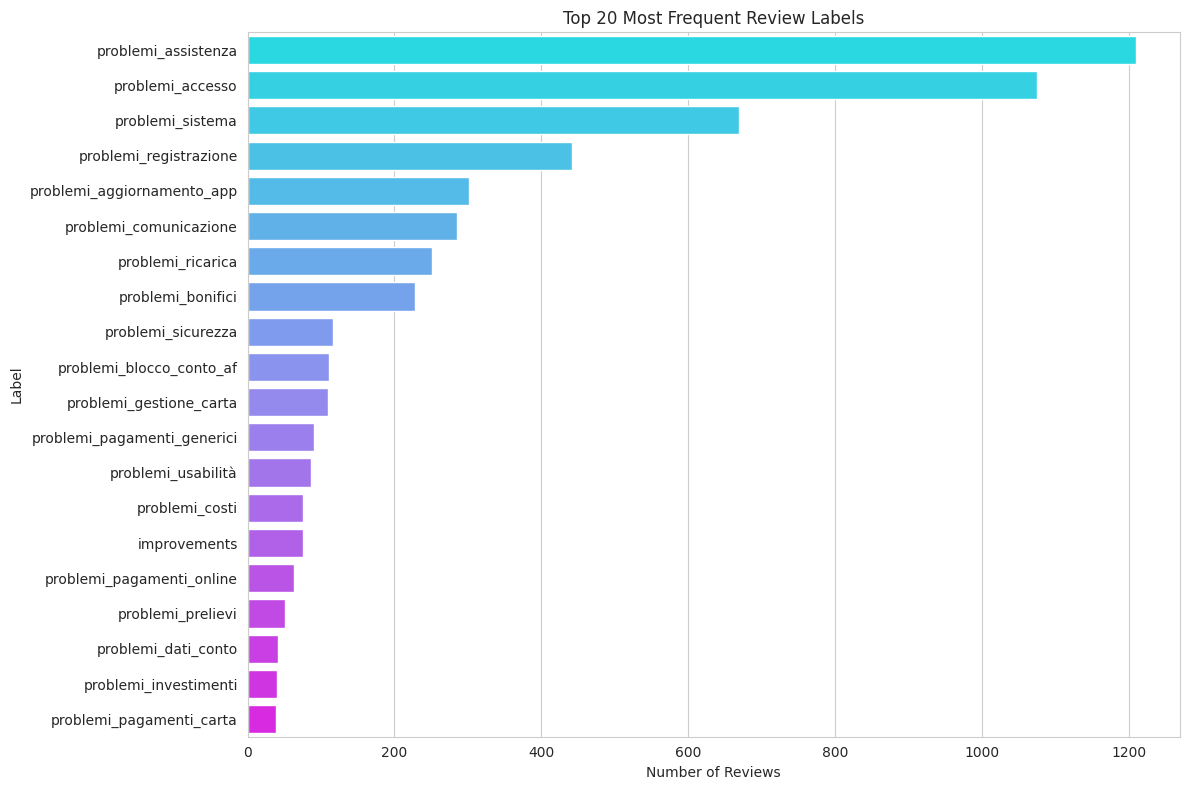

In [33]:
# Visualize the distribution of the top labels
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Label', hue='Label', data=label_counts_df.head(20), palette="cool", legend=False)
plt.title('Top 20 Most Frequent Review Labels')
plt.xlabel('Number of Reviews')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

##Analyze the trends of topics over time

Now we want to see the trend of top 20 most frequent labels in reviews during time

In [34]:
labels = list(df_taxonomy["LABEL"])[1:]

df_topics_trend = df_filtered[df_filtered["review_date"].isna()==False]

df_topics_trend.loc[:, "date"] = pd.to_datetime(df_topics_trend["review_date"], errors="coerce")
df_topics_trend = df_topics_trend.dropna(subset=["date"])

#One-hot encoding for tags
for label in labels:
    df_topics_trend.loc[:, label] = df_topics_trend["new_labels"].apply(lambda lst: label in lst)

df_topics_trend = df_topics_trend.set_index("date")

tag_time_series = df_topics_trend.resample("ME")[labels].sum()

top20_labels = label_counts_df.head(20)["Label"].tolist()
tag_time_series_top20 = tag_time_series[top20_labels]

As we can see, the trend follows the trend of the number of reviews per month and the distribution of the labels. There are no particularly significant patterns.

<Figure size 1400x700 with 0 Axes>

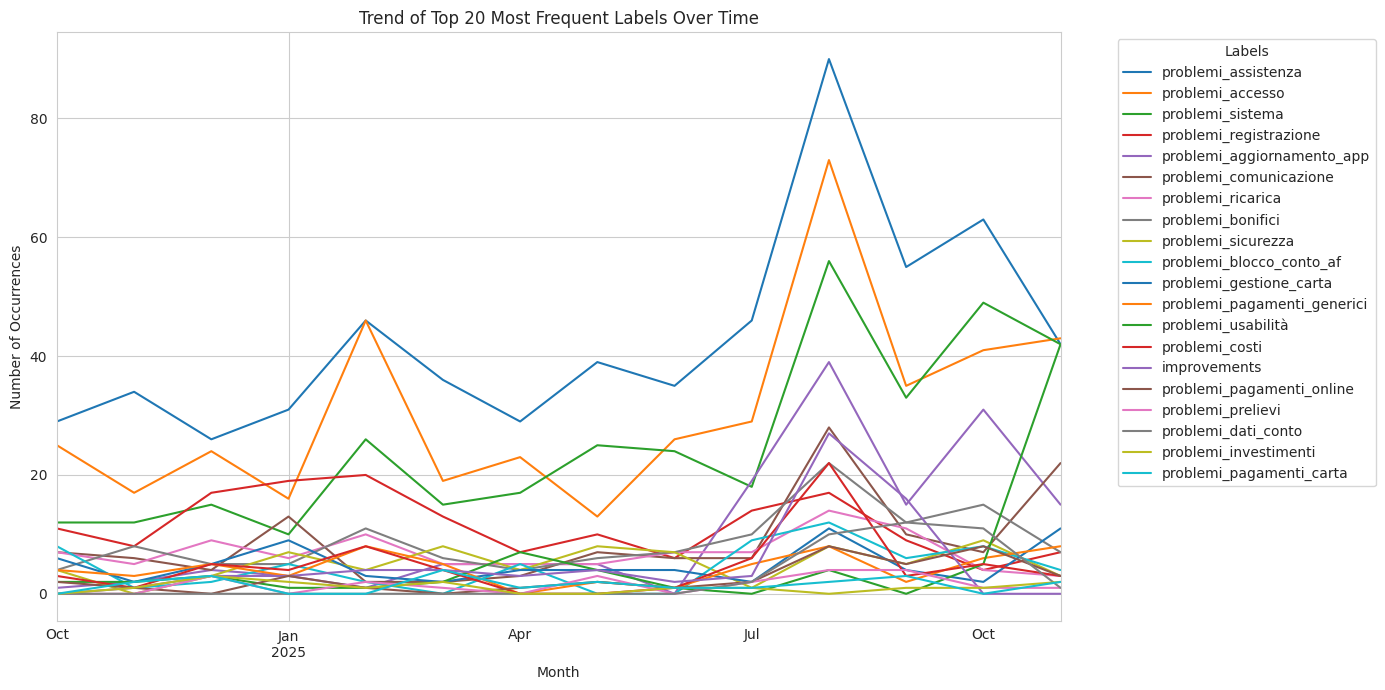

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
tag_time_series_top20.plot(figsize=(14,7))
plt.title("Trend of Top 20 Most Frequent Labels Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Occurrences")
plt.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Analysis of Rare Topics

To assess if rare topics contain enough samples to be modeled, let's look at the least frequent labels.

In [36]:
print("20 Least Frequent Labels:")
display(label_counts_df.tail(20))

20 Least Frequent Labels:


,Label,Count
28,problemi_f24,9
35,problemi_estero,7
36,problemi_trasferimento_denaro,6
37,problemi_ricarica_telefonica,6
22,problemi_circuiti_pagamento,5
30,problemi_gestione_conto,5
26,problemi_upgrade,3
38,problemi_download_app,3
50,problemi_di_usabilità,3
42,problemi_concorsi_bonus,2


Since we still have lots of labels with very low frequency, we can try to map each label to their parent label. In this way, we will have more general and less numerous labels to analyze, allowing us to understand the main pain points for costumers.

In [37]:
mapping_parent_df = df_taxonomy[df_taxonomy["LABEL"].notna()][["LABEL", "PARENT_LABEL"]]
child_to_parent = dict(zip(mapping_parent_df["LABEL"], mapping_parent_df["PARENT_LABEL"]))

def convert_tags(tag_list):
    if not isinstance(tag_list, list):
        return []

    new_tags = []
    for tag in tag_list:
        parent = child_to_parent.get(tag, np.nan)

        if pd.isna(parent):
            new_tags.append(tag)

        else:
            new_tags.append(parent)

    return new_tags

df_filtered["parent_label"] = df_filtered["new_labels"].apply(convert_tags)


In [38]:
child_to_parent

{'TODO': nan,
 'problemi_f24': 'problemi_pagamenti_generici',
 'problemi_pagamenti_carta': 'problemi_pagamenti_generici',
 'problemi_bollettini': 'problemi_pagamenti_generici',
 'problemi_bonifici': 'problemi_pagamenti_generici',
 'problemi_pagamenti_online': 'problemi_pagamenti_generici',
 'problemi_ricarica_telefonica': 'problemi_pagamenti_generici',
 'problemi_bitcoin': 'problemi_servizi_partner',
 'problemi_risparmi': nan,
 'problemi_accesso': nan,
 'problemi_aggiornamento_app': nan,
 'problemi_assistenza': nan,
 'problemi_blocco_conto_af': nan,
 'problemi_comunicazione': nan,
 'problemi_costi': nan,
 'problemi_pagamenti_generici': nan,
 'problemi_registrazione': nan,
 'problemi_ricarica': nan,
 'problemi_sistema': nan,
 'problemi_cashback': nan,
 'problemi_gestione_carta': nan,
 'problemi_investimenti': 'problemi_servizi_partner',
 'problemi_prelievi': nan,
 'problemi_sicurezza': nan,
 'problemi_trasferimento_denaro': nan,
 'problemi_usabilità': nan,
 'problemi_invio_denaro_hypers

In [39]:
labels_parent_occurencies = [label for sublist in df_filtered['parent_label'] for label in sublist]
all_labels_parent = sorted(set(label for sublist in df_filtered['parent_label'] for label in sublist))

# Count the frequency of each label
label_parents_counts = Counter(labels_parent_occurencies)

# Convert to a DataFrame for easier plotting and display
label_parents_counts_df = pd.DataFrame(label_parents_counts.items(), columns=['Label', 'Count'])
label_parents_counts_df = label_parents_counts_df.sort_values(by='Count', ascending=False)

Now let's see the top 20 most frequent labels after having mapped them to their parent labels

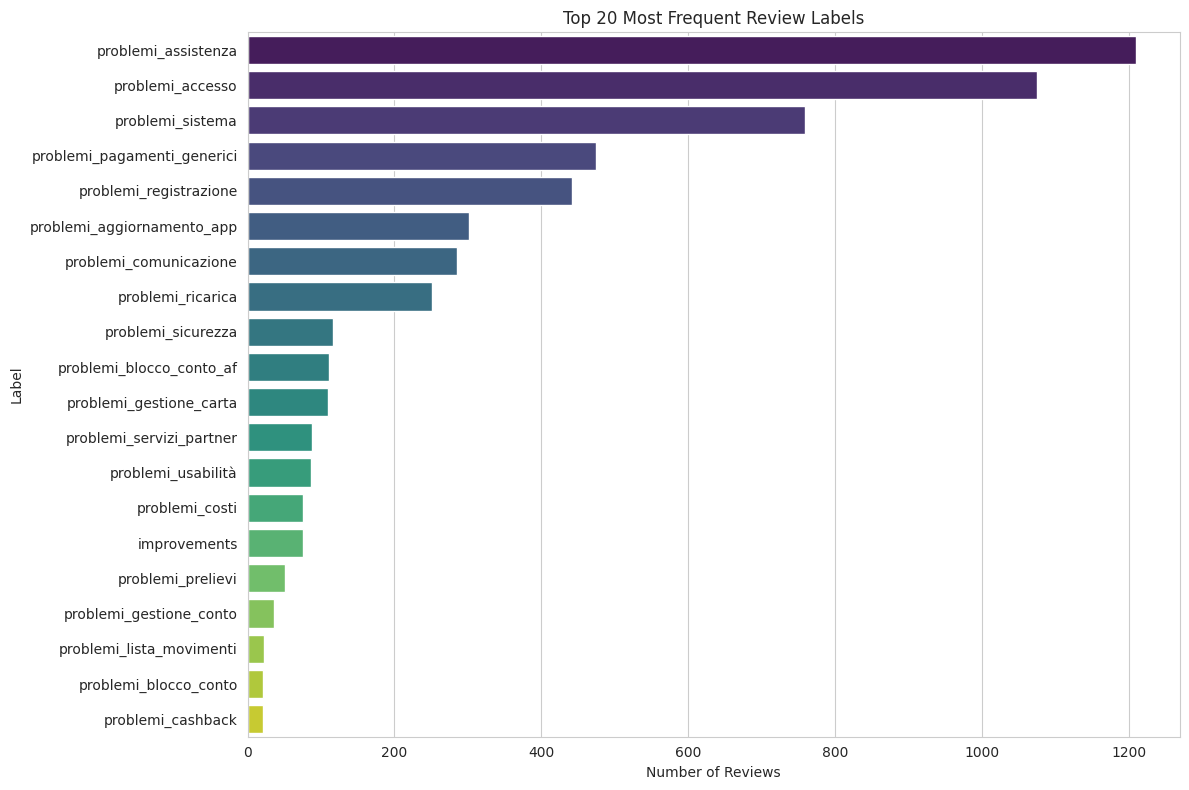

In [40]:
# Visualize the distribution of the top labels
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Label', hue='Label', data=label_parents_counts_df.head(20), palette='viridis', legend=False)
plt.title('Top 20 Most Frequent Review Labels')
plt.xlabel('Number of Reviews')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

We successfully reduced the number of labels. However, some of the least frequent labels are still very specific and may need to be aggregated in future processing.

In [41]:
print("Number of original labels:", len(all_labels))
print("Number of labels after mapping them to the new labels (updated name):", len(all_labels_new))
print("Number of labels after mapping them to their parent label:", len(all_labels_parent))

Number of original labels: 65
Number of labels after mapping them to the new labels (updated name): 52
Number of labels after mapping them to their parent label: 33


##Duplicate analysis

In [42]:
df["review"].duplicated().sum()

np.int64(304)

In [43]:
mask_duplicated = (df["review"].duplicated(keep=False) == True) & (df["review_length"]>20)
df[mask_duplicated].to_excel("duplicated.xlsx")
df[mask_duplicated]

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,...,language,language_full,tokens,punctuation_count,emoji_count,url_count,hashtag_count,repeated_chars,uppercase_ratio,is_50_percent_uppercase
284,00000038-3b3b-5103-04c4-4ee700000000,L app non si apre. Cancella e ri scarica ma ni...,negative,1.0,"[""problemi_sistema""]",1.0,1.0.0,2025-08-01,55,12,...,it,Italian,"[L, app, non, si, apre, ., Cancella, e, ri, sc...",5,1,0,0,0,0.036364,False
285,00000038-3b3b-5103-04c4-4ee700000000,L app non si apre. Cancella e ri scarica ma ni...,negative,1.0,"[""problemi_sistema""]",1.0,2.0.0,2025-08-01,55,12,...,it,Italian,"[L, app, non, si, apre, ., Cancella, e, ri, sc...",5,1,0,0,0,0.036364,False
286,00000038-3b3b-5103-04da-f36a00000000,La trovo piuttosto lenta ad avviarsi e poco ot...,negative,1.0,"[""problemi_sistema""]",1.0,1.0.0,2025-08-02,73,13,...,it,Italian,"[La, trovo, piuttosto, lenta, ad, avviarsi, e,...",1,0,0,0,0,0.041096,False
287,00000038-3b3b-5103-04da-f36a00000000,La trovo piuttosto lenta ad avviarsi e poco ot...,negative,1.0,"[""problemi_sistema""]",1.0,2.0.0,2025-08-02,55,9,...,it,Italian,"[La, trovo, piuttosto, lenta, ad, avviarsi, e,...",0,0,0,0,0,0.018182,False
288,00000038-3b3b-5103-04db-63d800000000,Da qualche giorno non si riesce più ad acceder...,negative,2.0,"[""problemi_accesso""]",1.0,1.0.0,2025-08-02,165,27,...,it,Italian,"[Da, qualche, giorno, non, si, riesce, più, ad...",2,0,0,0,0,0.030303,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,f4305652-cfe3-4847-a617-9816b1a43393,"fantastica app fantastico servizio, lo uso da ...",positive,5.0,[],1.0,1.0.0,2025-08-26,80,14,...,it,Italian,"[fantastica, app, fantastico, servizio, ,, lo,...",1,0,0,0,0,0.000000,False
3675,f4305652-cfe3-4847-a617-9816b1a43393,"fantastica app fantastico servizio, lo uso da ...",positive,5.0,[],1.0,2.0.0,2025-08-26,80,14,...,it,Italian,"[fantastica, app, fantastico, servizio, ,, lo,...",1,0,0,0,0,0.000000,False
3901,NaN,Assistenza inesistente,negative,NaN,"[""problemi_di_assistenza""]",NaN,1.0.0,NaT,22,2,...,de,German,"[Assistenza, inesistente]",0,0,0,0,0,0.045455,False
4254,NaN,Dopo l'ultimo aggiornamento è diventato imposs...,negative,NaN,"[""problemi_di_aggiornamento_app""]",NaN,1.0.0,NaT,122,18,...,it,Italian,"[Dopo, l'ultimo, aggiornamento, è, diventato, ...",1,0,0,0,0,0.024590,False


In [44]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_neg = df[df['rating'] <= 2].copy()
df_neg.reset_index(drop=True, inplace=True)

print("Number of negative reviews:", df_neg.shape[0])

# Exact duplicates
df_neg["is_exact_duplicate"] = df_neg.duplicated(subset="review", keep=False)
exact_dups = df_neg[df_neg["is_exact_duplicate"]]

print("Number of exact duplicates:", exact_dups.shape[0])

# Near duplicates (SIMILARITY >= 0.90)

corpus_neg = df_neg["review"].astype(str).tolist()

vectorizer = TfidfVectorizer(min_df=2, max_df=0.85)
X = vectorizer.fit_transform(corpus_neg)

sim_matrix = cosine_similarity(X)

threshold = 0.90
near_duplicates = []

for i in range(len(sim_matrix)):
    for j in range(i+1, len(sim_matrix)):
        if sim_matrix[i, j] >= threshold:
            near_duplicates.append((i, j, sim_matrix[i, j]))

near_dup_df = pd.DataFrame(near_duplicates,
                            columns=["idx1", "idx2", "similarity"])

print("Numero near-duplicates tra le negative:", near_dup_df.shape[0])

# Tagging duplicated reviews
df_neg["is_near_duplicate"] = False

for i, j, sim in near_duplicates:
    df_neg.loc[i, "is_near_duplicate"] = True
    df_neg.loc[j, "is_near_duplicate"] = True


percent = df_neg["is_near_duplicate"].mean() * 100
print(f"Percentage of near-duplicates in negative reviews: {percent:.2f}%")


print("\Examples of near-duplicates:\n")
for _, row in near_dup_df.iterrows():
    i, j = row["idx1"], row["idx2"]
    print(f"🔁 Similarità: {row['similarity']:.2f}")
    print("Review 1:", df_neg.loc[i, "review"])
    print("Review 2:", df_neg.loc[j, "review"])
    print("-" * 60)


Number of negative reviews: 1719
Number of exact duplicates: 83


<>:50: SyntaxWarning: invalid escape sequence '\E'
<>:50: SyntaxWarning: invalid escape sequence '\E'
/tmp/ipython-input-191449626.py:50: SyntaxWarning: invalid escape sequence '\E'
  print("\Examples of near-duplicates:\n")


Numero near-duplicates tra le negative: 96
Percentage of near-duplicates in negative reviews: 8.09%
\Examples of near-duplicates:

🔁 Similarità: 1.00
Review 1: Pessima
Review 2: pessima
------------------------------------------------------------
🔁 Similarità: 1.00
Review 1: Pessima
Review 2: pessima.
------------------------------------------------------------
🔁 Similarità: 0.95
Review 1: Non riesco ad entrare nell’app da tre giorni. Non posso accedere al mio conto e quindi al mio denaro. È inaccettabile
Review 2: Non riesco ad entrare nell’app da tre giorni. Non posso accedere al mio conto e quindi al mio denaro.
------------------------------------------------------------
🔁 Similarità: 1.00
Review 1: L app non si apre. Cancella e ri scarica ma niente 🤷‍♂️
Review 2: L app non si apre. Cancella e ri scarica ma niente 🤷‍♂️
------------------------------------------------------------
🔁 Similarità: 1.00
Review 1: La trovo piuttosto lenta ad avviarsi e poco ottimizzata per il mondo iOS.
R

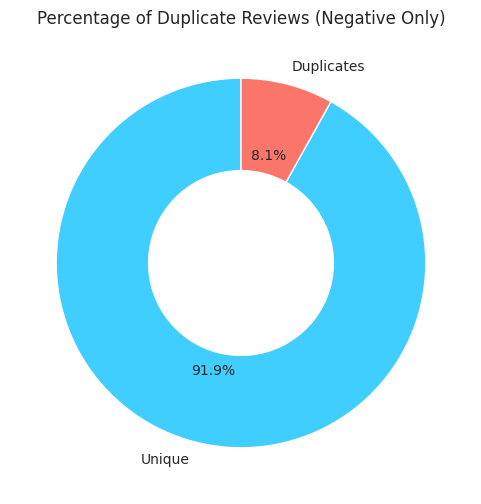

In [45]:
sizes = [
    df_neg.shape[0] - df_neg["is_near_duplicate"].sum(),
    df_neg["is_near_duplicate"].sum()
]

labels = ["Unique", "Duplicates"]
colors = ["#40cdff", "#fb766a"]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90, wedgeprops={"width":0.5})
plt.title("Percentage of Duplicate Reviews (Negative Only)")
plt.show()


In [46]:
df.columns

Index(['id_review', 'review', 'sentiment', 'rating', 'labels',
       'is_labels_validated', 'model_version', 'review_date', 'review_length',
       'review_word_count', 'date', 'language', 'language_full', 'tokens',
       'punctuation_count', 'emoji_count', 'url_count', 'hashtag_count',
       'repeated_chars', 'uppercase_ratio', 'is_50_percent_uppercase'],
      dtype='object')

## Oulier analysis
**Outlier** = a statistically anomalous review (but it may still be meaningful)

**Junk review** = a semantically useless review (should be removed)

Set thresholds for noise features and identify reviews exceeding them to assess if they are 'junk' or 'outliers'.



To identify reviews with excessive noise, I need to define specific thresholds for each noise feature (emoji count, URL count, hashtag count, repeated characters, and uppercase ratio) and then flag reviews that exceed any of these thresholds. This step will create a new boolean column `is_noisy_review` to mark such reviews.



In [47]:
import numpy as np

# 1. Define threshold values for each noise feature
thresholds = {
    'emoji_count': 2,        # More than 2 emojis
    'url_count': 0,          # Any URL present
    'hashtag_count': 0,      # Any hashtag present
    'repeated_chars': 2,     # More than 2 patterns of repeated characters (e.g., '!!!!', '???', 'ooooo')
    'uppercase_ratio': 0.5   # More than 50% of characters are uppercase
}

# 2. Create a new boolean column `is_noisy_review`
# Initialize the column to False
df['is_noisy_review'] = False

# Apply thresholds
df.loc[df['emoji_count'] > thresholds['emoji_count'], 'is_noisy_review'] = True
df.loc[df['url_count'] > thresholds['url_count'], 'is_noisy_review'] = True
df.loc[df['hashtag_count'] > thresholds['hashtag_count'], 'is_noisy_review'] = True
df.loc[df['repeated_chars'] > thresholds['repeated_chars'], 'is_noisy_review'] = True
df.loc[df['uppercase_ratio'] > thresholds['uppercase_ratio'], 'is_noisy_review'] = True
#CONSIDER OTHER THRESHOLD AND FEATURES LOOKING FOR LITERATURE

# 3. Filter and display a sample of reviews where `is_noisy_review` is `True`
noisy_reviews_sample = df[df['is_noisy_review'] == True]

print(f"Total noisy reviews identified: {len(noisy_reviews_sample)}")
print("\nSample of noisy reviews:")
display(noisy_reviews_sample[[
    'review', 'emoji_count', 'url_count', 'hashtag_count',
    'repeated_chars', 'uppercase_ratio', 'sentiment', 'rating'
]].sample(min(10, len(noisy_reviews_sample))))

Total noisy reviews identified: 201

Sample of noisy reviews:


,review,emoji_count,url_count,hashtag_count,repeated_chars,uppercase_ratio,sentiment,rating
4518,Hype era partito bene; poche e semplici funzio...,0,0,0,9,0.024515,negative,NaN
4961,Non ho potuto neanche usare l'app per via di u...,3,0,0,1,0.011561,negative,NaN
2368,"MI CHIAMO ANDREA RICCI, HO 43 ANNI E VIVO A TO...",0,0,0,3,0.802759,positive,1.0
5913,da quasi un mese la sezione investimenti non c...,0,0,0,4,0.033994,negative,NaN
1635,Ho usato il conto hype per due tre anni con la...,0,0,0,3,0.004107,negative,1.0
2396,Mi è stato bloccato il conto per una truffa s...,0,0,0,3,0.002506,negative,1.0
5956,inaccettabile non avere accesso ai propri inve...,0,0,0,3,0.006579,negative,NaN
4481,Ho provato almeno 4 volte a registrarmi con l'...,3,0,0,0,0.010638,negative,NaN
3318,delusione... con mio figlio minorenne è da 3 g...,0,0,0,4,0.000000,negative,1.0
4335,"Finché non ci sono problemi, tutto ok. Poi ......",1,0,0,3,0.023041,negative,NaN


In [48]:
df.columns

Index(['id_review', 'review', 'sentiment', 'rating', 'labels',
       'is_labels_validated', 'model_version', 'review_date', 'review_length',
       'review_word_count', 'date', 'language', 'language_full', 'tokens',
       'punctuation_count', 'emoji_count', 'url_count', 'hashtag_count',
       'repeated_chars', 'uppercase_ratio', 'is_50_percent_uppercase',
       'is_noisy_review'],
      dtype='object')

In [49]:
import numpy as np
import langdetect
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# 1. Compute additional features

# Count special characters (excluding emoji)
df['special_char_count'] = df['review'].astype(str).apply(
    lambda x: sum(not c.isalnum() and c not in " " for c in x)
)

# Ratio of digits in text
df['digit_ratio'] = df['review'].astype(str).apply(
    lambda x: sum(c.isdigit() for c in x) / max(1, len(x))
)

# Detect non-Italian language
df['is_non_italian'] = df['language'] != "it"

# Compute rare-token ratio (using TF-IDF)
vectorizer = TfidfVectorizer(min_df=5)  # tokens appearing <5 times are rare
X = vectorizer.fit_transform(df['review'].astype(str))

idf = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))
df['rare_token_ratio'] = df['review'].apply(
    lambda text: np.mean([idf.get(t, max(idf.values())) > np.percentile(list(idf.values()), 90)
                          for t in text.split()]) if isinstance(text, str) else 0
)

# Token entropy (low entropy = repetitive text)
def entropy(text):
    tokens = text.split()
    counts = Counter(tokens)
    probs = [c/len(tokens) for c in counts.values()]
    return -sum(p * np.log2(p) for p in probs)

df['token_entropy'] = df['review'].astype(str).apply(entropy)

# 2. RULE-BASED THRESHOLDS (from literature)

thresholds = {
    'emoji_count': 2,
    'url_count': 0,
    'hashtag_count': 0,
    'repeated_chars': 2,
    'uppercase_ratio': 0.5,
    'char_length_short': 15,        # <15 chars = junk
    'word_count_short': 3,          # <3 words = junk
    'char_length_long': 600,        # >600 chars = outlier
    'special_char_count': 15,
    'digit_ratio': 0.3,
    'rare_token_ratio': 0.4,
    'token_entropy_low': 1.2,       # repetitive text
}

df['is_rule_outlier'] = False

# Apply thresholds
df.loc[df['emoji_count'] > thresholds['emoji_count'], 'is_rule_outlier'] = True
df.loc[df['url_count'] > thresholds['url_count'], 'is_rule_outlier'] = True
df.loc[df['hashtag_count'] > thresholds['hashtag_count'], 'is_rule_outlier'] = True
df.loc[df['repeated_chars'] > thresholds['repeated_chars'], 'is_rule_outlier'] = True
df.loc[df['uppercase_ratio'] > thresholds['uppercase_ratio'], 'is_rule_outlier'] = True
df.loc[df['review_length'] < thresholds['char_length_short'], 'is_rule_outlier'] = True
df.loc[df['review_word_count'] < thresholds['word_count_short'], 'is_rule_outlier'] = True
df.loc[df['review_length'] > thresholds['char_length_long'], 'is_rule_outlier'] = True
df.loc[df['special_char_count'] > thresholds['special_char_count'], 'is_rule_outlier'] = True
df.loc[df['digit_ratio'] > thresholds['digit_ratio'], 'is_rule_outlier'] = True
df.loc[df['rare_token_ratio'] > thresholds['rare_token_ratio'], 'is_rule_outlier'] = True
df.loc[df['token_entropy'] < thresholds['token_entropy_low'], 'is_rule_outlier'] = True
df.loc[df['is_non_italian'] == True, 'is_rule_outlier'] = True


print(f"Rule-based outliers detected: {df['is_rule_outlier'].sum()}")

Rule-based outliers detected: 1156


In [50]:
df[df['is_rule_outlier']==True]

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,...,repeated_chars,uppercase_ratio,is_50_percent_uppercase,is_noisy_review,special_char_count,digit_ratio,is_non_italian,rare_token_ratio,token_entropy,is_rule_outlier
5,00000038-3b3b-5102-c026-8ea700000000,Ottimo servizio,positive,5.0,[],0.0,1.0.0,2024-10-09,15,2,...,0,0.066667,False,False,0,0.000000,False,0.0,1.000000,True
26,00000038-3b3b-5102-c6aa-907000000000,Fino a un mese fa tutto ok \nOra dopo il cambi...,negative,3.0,"[""problemi_assistenza""]",0.0,1.0.0,2024-11-07,776,133,...,0,0.007732,False,False,13,0.000000,False,0.0,6.557246,True
30,00000038-3b3b-5102-c7cc-dd3600000000,BRAVISSIMI,positive,5.0,[],0.0,1.0.0,2024-11-12,10,1,...,0,1.000000,True,True,0,0.000000,True,0.0,-0.000000,True
37,00000038-3b3b-5102-c918-cc3d00000000,"Pessima assistenza da parte di Hype ,per non d...",negative,1.0,"[""problemi_assistenza""]",0.0,1.0.0,2024-11-18,1309,223,...,1,0.006875,False,False,29,0.002292,False,0.0,6.905730,True
40,00000038-3b3b-5102-c997-2ff300000000,Perfetta,positive,5.0,[],0.0,1.0.0,2024-11-20,8,1,...,0,0.125000,False,False,0,0.000000,True,0.0,-0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6126,NaN,È spesso (sempre) in manutenzione/ aggiornamen...,negative,NaN,"[""problemi_di_comunicazione""]",NaN,1.0.0,NaT,1160,191,...,2,0.015517,False,False,33,0.000000,False,0.0,6.877832,True
6128,NaN,È tutto il giorno che da errore....senza motiv...,negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT,175,30,...,4,0.005714,False,True,16,0.000000,False,0.0,4.548394,True
6131,NaN,"È un po’ di anni che la uso, ottima ma… È cari...",negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT,439,79,...,2,0.018223,False,False,21,0.013667,False,0.0,5.860495,True
6137,NaN,"É bonito, intuitivo. Mas acontece um bug com M...",negative,NaN,"[""problemi_di_accesso""]",NaN,1.0.0,NaT,243,45,...,0,0.037037,False,False,9,0.000000,True,0.0,5.269631,True


Although the outlier detection methods identify a relatively large number of reviews, manual inspection shows that these instances still contain valuable linguistic content relevant to topic detection. For this reason, we wiil not exclude them from the dataset.

Some reviews contain only one meaningless word or only emojis/punctuation, these could be considered junk reviews.

In [53]:
import pandas as pd
import re

# Define your dataset column
text_col = "review"

# List of sample meaningless short words
meaningless_words = {
    "ok", "okay", "si", "no", "mah", "boh",
    "ciao", "hello", "hi", "hey",
    "bene", "male", "bravo", "nice", "good", "bad", "pessima", "scadente"
}

# Function to check if a review is junk
def is_junk(text):
    if not isinstance(text, str):
        return True

    stripped = text.strip()

    # 1. Empty string
    if stripped == "":
        return True

    # 2. Only emojis or punctuation
    if all(not c.isalnum() for c in stripped):
        return True

    # 3. Remove punctuation & check word count
    cleaned = re.sub(r"[^A-Za-z0-9àèéìòùç ]", "", stripped).lower().strip()
    words = cleaned.split()

    # 4. Only one meaningless word
    if len(words) == 1 and words[0] in meaningless_words:
        return True

    return False

# Apply detection
df["is_junk_review"] = df[text_col].apply(is_junk)

# Extract junk samples
junk_reviews = df[df["is_junk_review"] == True]

print(f"Number of junk reviews: {len(junk_reviews)}")

Number of junk reviews: 26


In [54]:
junk_reviews

,id_review,review,sentiment,rating,labels,is_labels_validated,model_version,review_date,review_length,review_word_count,...,uppercase_ratio,is_50_percent_uppercase,is_noisy_review,special_char_count,digit_ratio,is_non_italian,rare_token_ratio,token_entropy,is_rule_outlier,is_junk_review
59,00000038-3b3b-5102-cdd2-ec9600000000,Pessima,negative,1.0,[],0.0,1.0.0,2024-12-09,7,1,...,0.142857,False,False,0,0.0,True,0.0,-0.0,True,True
442,00000038-3b3b-5103-0cf5-068c00000000,.,neutral,5.0,[],1.0,2.0.0,2025-09-05,1,1,...,0.000000,False,False,1,0.0,True,0.0,-0.0,True,True
705,011b11df-93c9-48cd-b0c3-748ded695c81,bene,positive,5.0,[],1.0,1.0.0,2025-04-27,4,1,...,0.000000,False,False,0,0.0,True,0.0,-0.0,True,True
760,08802a63-39e6-479a-acb2-3a978ae27a79,👍,positive,5.0,[],1.0,1.0.0,2025-08-05,1,1,...,0.000000,False,False,1,0.0,True,0.0,-0.0,True,True
761,08802a63-39e6-479a-acb2-3a978ae27a79,👍,positive,5.0,[],1.0,2.0.0,2025-08-05,1,1,...,0.000000,False,False,1,0.0,True,0.0,-0.0,True,True
802,0d2824e7-ab64-4c7b-9be2-1ddfa1266cf6,👏👏👏👏,positive,5.0,[],0.0,1.0.0,2024-12-02,4,1,...,0.000000,False,True,4,0.0,True,0.0,-0.0,True,True
964,247a92ab-32fb-46d2-904b-4fd398190ecc,bene,positive,5.0,[],0.0,1.0.0,2024-12-26,4,1,...,0.000000,False,False,0,0.0,True,0.0,-0.0,True,True
972,24fbc469-1150-4b33-a70b-dfa2d820202b,Scadente,negative,1.0,[],0.0,1.0.0,2025-01-14,8,1,...,0.125000,False,False,0,0.0,True,0.0,-0.0,True,True
1070,2f93489e-555b-4ca3-9ffd-bd68357aa95a,ok,neutral,5.0,[],0.0,1.0.0,2025-02-09,2,1,...,0.000000,False,False,0,0.0,True,0.0,-0.0,True,True
1155,3aad991f-f7ab-46c9-9aed-ec8c73d5bfed,ok,positive,5.0,[],1.0,2.0.0,2025-09-17,2,1,...,0.000000,False,False,0,0.0,True,0.0,-0.0,True,True
